In [1]:
import pandas as pd 
import numpy as np 
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotions-dataset-for-nlp/val.txt
/kaggle/input/emotions-dataset-for-nlp/test.txt
/kaggle/input/emotions-dataset-for-nlp/train.txt
/kaggle/input/velat-veri/40k_dataset.csv


In [2]:
df = pd.read_csv("/kaggle/input/velat-veri/40k_dataset.csv")

# Verileri birleştirin
df.head()
len(df)

39996

In [3]:
df=df.drop_duplicates()

In [4]:
df.head()

len(df)

39985

In [5]:
df.head()


,text,label
0,i just feel really sad,0
1,i feel like i rejected her,0
2,i feel completely humiliated in front of my ki...,0
3,i feel jaded and sick of it all,0
4,i hate when i feel stupid because i dont know ...,0


In [6]:
##şimdi verimize baktıgımızda class sutununda kategorik veriler ve  
df["label"].unique() 

array([0, 1, 2, 3, 4, 5])

In [7]:
##şimdi data verilerimizi ön işlemden geçireceğiz.
##bunun için bert'in kendi tokenizer'ini kullanacağız.
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
id2label = {0: "üzgün", 1: "mutluluk",2: "romantik",3: "kızgın",4: "korku",5: "sürpriz"}
label2id = {"üzgün": 0, "mutluluk": 1,"romantik": 2,"kızgın": 3,"korku": 4,"sürpriz": 5}



In [9]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=6, id2label=id2label, label2id=label2id
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
df.head()
df.columns

Index(['text', 'label'], dtype='object')

In [11]:
df.head()

,text,label
0,i just feel really sad,0
1,i feel like i rejected her,0
2,i feel completely humiliated in front of my ki...,0
3,i feel jaded and sick of it all,0
4,i hate when i feel stupid because i dont know ...,0


In [12]:
from torch.utils.data import DataLoader,Dataset


class CustomDataset(Dataset):
    def __init__(self, dataframe,tokenizer):
        self.dataframe = dataframe
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Girdi ve etiket sütunlarını ayır
        input_data = self.dataframe.iloc[idx, 0]  # İlk sütun
        labels = torch.tensor(self.dataframe.iloc[idx, 1])
       

        encoded_text = self.tokenizer(input_data,
                                      max_length=64,
                                      padding='max_length',
                                      truncation=True
                                     
                                     )

        input_ids = torch.tensor(encoded_text['input_ids'])
        attention_masks = torch.tensor(encoded_text['attention_mask'])
        return input_ids,attention_masks,labels

In [13]:

from sklearn.model_selection import train_test_split
train,test = train_test_split(df, test_size=0.20, random_state=42)

train_dataset = CustomDataset(train,tokenizer)
test_dataset=CustomDataset(test,tokenizer)




In [14]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)
eval_dataloader  = DataLoader(test_dataset, batch_size=16)

In [15]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [16]:
from transformers import get_scheduler

num_epochs = 5
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [17]:
model.train()
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    for batch_idx, (input_ids, attention_masks, labels) in enumerate(train_dataloader):
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        # Her batch sonunda loss'u yazdır
        print(f"Batch {batch_idx + 1}/{len(train_dataloader)}, Loss: {loss.item():.4f}")



Epoch 1/5
Batch 1/2000, Loss: 1.8107
Batch 2/2000, Loss: 1.7742
Batch 3/2000, Loss: 1.8168
Batch 4/2000, Loss: 1.8117
Batch 5/2000, Loss: 1.7993
Batch 6/2000, Loss: 1.7835
Batch 7/2000, Loss: 1.8240
Batch 8/2000, Loss: 1.7503
Batch 9/2000, Loss: 1.8497
Batch 10/2000, Loss: 1.8297
Batch 11/2000, Loss: 1.8005
Batch 12/2000, Loss: 1.8505
Batch 13/2000, Loss: 1.7969
Batch 14/2000, Loss: 1.7785
Batch 15/2000, Loss: 1.8198
Batch 16/2000, Loss: 1.7387
Batch 17/2000, Loss: 1.8258
Batch 18/2000, Loss: 1.7714
Batch 19/2000, Loss: 1.7722
Batch 20/2000, Loss: 1.7477
Batch 21/2000, Loss: 1.7504
Batch 22/2000, Loss: 1.7240
Batch 23/2000, Loss: 1.7109
Batch 24/2000, Loss: 1.7421
Batch 25/2000, Loss: 1.6697
Batch 26/2000, Loss: 1.6687
Batch 27/2000, Loss: 1.7835
Batch 28/2000, Loss: 1.6666
Batch 29/2000, Loss: 1.5536
Batch 30/2000, Loss: 1.5752
Batch 31/2000, Loss: 1.5726
Batch 32/2000, Loss: 1.4940
Batch 33/2000, Loss: 1.5797
Batch 34/2000, Loss: 1.4446
Batch 35/2000, Loss: 1.6580
Batch 36/2000, Loss

Accuracy: 0.9512
Precision: 0.9527
Recall: 0.9512
F1 Score: 0.9510


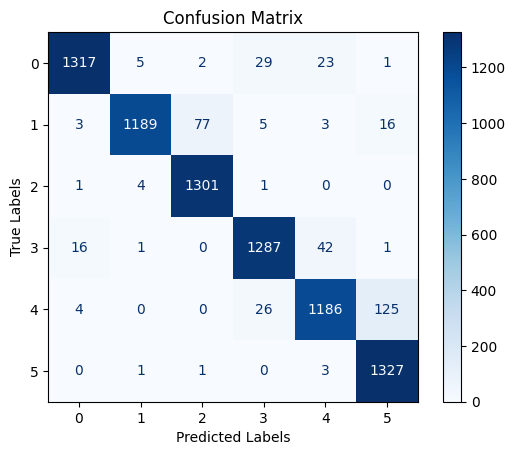

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import torch

# Modeli evaluation moduna geçir
model.eval()

all_preds = []
all_labels = []

# Test verisi üzerinde değerlendirme
with torch.no_grad():
    for input_ids, attention_masks, labels in eval_dataloader:
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)

        # Modelden tahminler al
        outputs = model(input_ids=input_ids, attention_mask=attention_masks)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Performans metriklerini hesapla
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average="weighted")
recall = recall_score(all_labels, all_preds, average="weighted")
f1 = f1_score(all_labels, all_preds, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix çizimi
conf_matrix = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap="Blues")
disp.ax_.set_title("Confusion Matrix")
disp.ax_.set_xlabel("Predicted Labels")
disp.ax_.set_ylabel("True Labels")
plt.show()


In [27]:
from transformers import AutoTokenizer
import torch

# Tokenizer yükle

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")


def predict_sentence(model, sentence):
    # Cümleyi token'lara dönüştür ve tensör haline getir
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True, max_length=512)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    # Modelden tahmin al
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

    return preds.cpu().item()  # Tek bir tahmin döndüğü için item() kullanıyoruz

# Test cümlesi
sentence = "Despite trying my best to stay positive, everything around me feels heavy and overwhelming, leaving me with a deep sense of sadness"
predicted_label = predict_sentence(model, sentence)
print(model.config.id2label[predicted_label])



üzgün


In [28]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import os
# Modeli kaydetmek için bir dizin oluştur
save_directory = "./bert_finetuned_model_2"
os.makedirs(save_directory, exist_ok=True)

# Fine-tune edilmiş modeli ve tokenizer'ı kaydet
model.save_pretrained(save_directory)
tokenizer = tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased") # Tokenizer'ı belirtin
tokenizer.save_pretrained(save_directory)

print(f"Model ve tokenizer {save_directory} dizinine kaydedildi.")


Model ve tokenizer ./bert_finetuned_model_2 dizinine kaydedildi.


In [32]:
import shutil

# Kaydedilen modeli output dizinine taş
shutil.move(save_directory, "/kaggle/working/bert_finetuned_model_2")

print("Model /kaggle/working/bert_finetuned_model dizinine taşındı.")


Model /kaggle/working/bert_finetuned_model dizinine taşındı.


In [31]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Kaydedilen model ve tokenizer'ı yükle
load_directory = "/kaggle/working/bert_finetuned_model_2"
modelsave = AutoModelForSequenceClassification.from_pretrained(load_directory)
tokenizersave = AutoTokenizer.from_pretrained(load_directory)

print("Model ve tokenizer başarıyla yüklendi.")


Model ve tokenizer başarıyla yüklendi.
